In [1]:
import os
import h5py    
import numpy as np 
import pandas
import csv
from matplotlib import pyplot as plt
from random import randint

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, ZeroPadding2D, Reshape, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers

from kerastuner.tuners import RandomSearch

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

clear_session()

# Verify GPU usage and extract data from h5

In [2]:
import tensorflow as tf
print(f"Number of GPUs available : {len(tf.config.experimental.list_physical_devices('GPU'))} ")

f = h5py.File('MNIST_synthetic.h5', 'r')
train = f['train_dataset'][...]
train_labels = f['train_labels'][...]
validation = f['test_dataset'][...]
f.close()

Number of GPUs available : 1 


# Get train/test split and reshape them for CNN

In [3]:
train_images, val_images, y_train_label, y_val_label = train_test_split(train, train_labels, test_size=0.2, shuffle=True)

ln_train_images = train_images.shape[0]
ln_val_images = val_images.shape[0]
ln_split = train.shape[0]

x_train_input_temp = train_images.reshape(ln_train_images,64,64,1).astype('float32')
x_val_input_temp = val_images.reshape(ln_val_images,64,64,1).astype('float32')
x_test_input_temp = train.reshape(ln_split,64,64,1).astype('float32')

print ('x_train:', x_train_input_temp.shape)
print ('x_test:', x_val_input_temp.shape)

x_train: (44800, 64, 64, 1)
x_test: (11200, 64, 64, 1)


# Normalize the data

In [4]:
validation# Normalize data
x_train_input = x_train_input_temp / 255
x_val_input = x_val_input_temp / 255
x_test_input = x_test_input_temp / 255

y_train_label = to_categorical(y_train_label)
y_val_label = to_categorical(y_val_label)

# Use Keras tuner to search for best hyper-parameters

1) Number of hidden layers

2) Number of neurons in the hidden layers

3) Learning rate

In [29]:
def build_model(hp):
    
    width=64
    height=64
    depth=1
    model = Sequential()

    # Convolution: TODO verify filter size
    model.add(Conv2D(filters=64,kernel_size=(2,2),padding='same', input_shape=(width,height,depth), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64*2,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))    
    model.add(Conv2D(filters=64*3,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64*4,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64*5,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())

    # Fully connected layers
    for i in range(hp.Int('num_layers', 2, 5)): # We want maximum 2-4 layers, decided from previous trial/error
        model.add(Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=384, step=32),
            activation='swish'
        ))
        model.add(Dropout(
            rate=hp.Float('dropout_1', min_value=0.0, max_value=0.4, default=0.1, step=0.05) 
        ))

    model.add(Dense(5*11,activation='sigmoid'))
    model.add(Reshape( (5,11) )) 
    
    # Test out different learning rates for Adam
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.003, 0.005])),
        loss=BinaryCrossentropy(),
        metrics=['accuracy'])
    
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='project_5',
    project_name='models')

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 384, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.05, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 384, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.003, 0.005], 'ordered': True}


In [30]:
tuner.search(
    x=x_train_input, # Train on origional dataset, not augmented dataset to get most consistent results
    y=y_train_label,
    validation_data=(x_val_input, y_val_label),
    epochs=6,
)

Trial 5 Complete [00h 15m 45s]
val_accuracy: 0.9859071373939514

Best val_accuracy So Far: 0.9905107140541076
Total elapsed time: 10h 36m 56s
INFO:tensorflow:Oracle triggered exit


In [31]:
tuner.results_summary()

Results summary
Results in project_5\models
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 288
dropout_1: 0.15000000000000002
units_1: 224
learning_rate: 0.001
units_2: 128
Score: 0.9905107140541076
Trial summary
Hyperparameters:
num_layers: 3
units_0: 288
dropout_1: 0.05
units_1: 256
learning_rate: 0.001
units_2: 32
Score: 0.9901571393013
Trial summary
Hyperparameters:
num_layers: 4
units_0: 320
dropout_1: 0.05
units_1: 320
learning_rate: 0.001
units_2: 352
units_3: 32
Score: 0.9874071478843689
Trial summary
Hyperparameters:
num_layers: 4
units_0: 224
dropout_1: 0.15000000000000002
units_1: 64
learning_rate: 0.001
units_2: 224
units_3: 384
Score: 0.9859071373939514
Trial summary
Hyperparameters:
num_layers: 3
units_0: 352
dropout_1: 0.05
units_1: 32
learning_rate: 0.005
units_2: 384
units_3: 96
Score: 0.9479857206344604


# Create model based on keras tuner

In [9]:
def create_cnn(width=64, height=64, depth=1):
    model = Sequential()
    
    # Convolution
    model.add(Conv2D(filters=64,kernel_size=(2,2),padding='same', input_shape=(width,height,depth), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=128,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=256,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(Conv2D(filters=256,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(Conv2D(filters=256,kernel_size=(2,2),padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    
    # Fully connected
    model.add(Dense(288, activation='swish'))
    model.add(Dense(224, activation='swish'))
    model.add(Dropout(0.150))
    model.add(Dense(5*11,activation='sigmoid'))
    model.add(Reshape( (5,11) ))
    return model


cnn1 = create_cnn(64, 64, 1)
model = Model(inputs=cnn1.inputs, outputs = cnn1.outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       65664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0     

# Working with the model

In [10]:
# Once we've trained with k-fold validation, we want to train the model with ALL the data,
# then test it out / verify that we don't have overfitting
f = h5py.File('MNIST_synthetic.h5', 'r')
train = f['train_dataset'][...]
train_labels = f['train_labels'][...]
validation = f['test_dataset'][...]
f.close()

train_images, val_images, y_train_label, y_val_label = train_test_split(train, train_labels, test_size=0.1, shuffle=True)

ln_train_images = train_images.shape[0]
ln_val_images = val_images.shape[0]
ln_split = train.shape[0]

x_train_input_temp = train_images.reshape(ln_train_images,64,64,1).astype('float32')
x_val_input_temp = val_images.reshape(ln_val_images,64,64,1).astype('float32')
x_test_input_temp = train.reshape(ln_split,64,64,1).astype('float32')

x_train_input = x_train_input_temp / 255
x_val_input = x_val_input_temp / 255
x_test_input = x_test_input_temp / 255

y_train_label = to_categorical(y_train_label)
y_val_label = to_categorical(y_val_label)

# Data augmentation

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    shear_range=0.07,
    width_shift_range=0.05,
    height_shift_range=0.06,
    horizontal_flip=False)

# Fit the model

In [12]:
cnn1 = create_cnn(64, 64, 1)
model = Model(inputs=cnn1.inputs, outputs = cnn1.outputs)
model.compile(
    optimizer=Adam(lr=0.001), #0.001
    loss=BinaryCrossentropy(),
    metrics=['accuracy'])

x_train_input_gen = x_train_input # To make sure we don't end up changing the origional dataset
datagen.fit(x_train_input_gen)

batchSize = 32
nrEpochs = 18
model.fit(datagen.flow(x_train_input_gen, y_train_label, batch_size=batchSize),
          steps_per_epoch=len(x_train_input_gen) / batchSize, 
          epochs=nrEpochs)

'''
NOTE:
Due to the deadline approaching,
the code was not able to fully evaluate, however 
the code does not take long to compile and run.

The epoch used for the highest validation accuracy was 11 and the learning rate lr was 0.001
'''

Epoch 1/18
1575/1575 [==============================] - 60s 36ms/step - loss: 0.1465 - accuracy: 0.6631
Epoch 2/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0235 - accuracy: 0.9719
Epoch 3/18
1575/1575 [==============================] - 60s 38ms/step - loss: 0.0154 - accuracy: 0.9832
Epoch 4/18
1575/1575 [==============================] - 59s 37ms/step - loss: 0.0125 - accuracy: 0.9866
Epoch 5/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0106 - accuracy: 0.9890
Epoch 6/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0094 - accuracy: 0.9901
Epoch 7/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0084 - accuracy: 0.9912
Epoch 8/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0078 - accuracy: 0.9920
Epoch 9/18
1575/1575 [==============================] - 58s 37ms/step - loss: 0.0072 - accuracy: 0.9926
Epoch 10/18
1575/1575 [==============================] - 58s 37m

# Verify validation accuracy

In [13]:
_, acc = model.evaluate(val_images, y_val_label)
print(f'Validation accuracy : {acc*100}%')

175/175 [==============================] - 2s 11ms/step - loss: 0.0862 - accuracy: 0.9375
Validation accuracy : 93.75357031822205%


           Label
Id              
12163  610101010


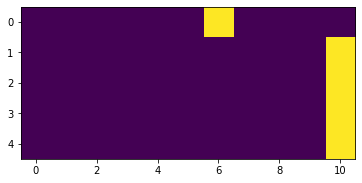

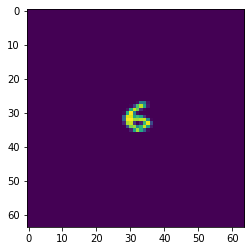

          Label
Id             
12164  00101010


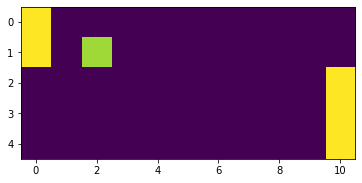

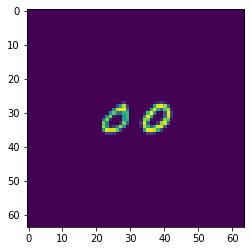

          Label
Id             
12165  70101010


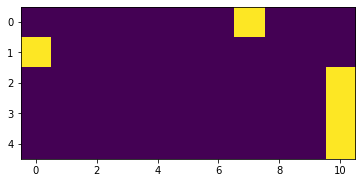

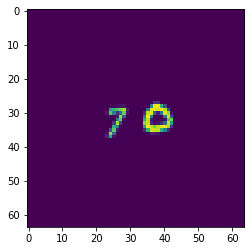

           Label
Id              
12166  010101010


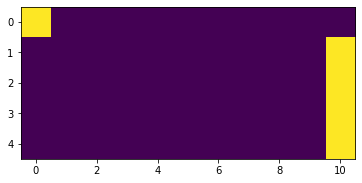

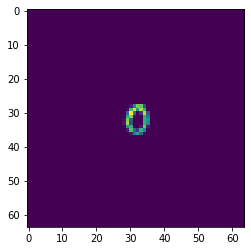

       Label
Id          
12167  49001


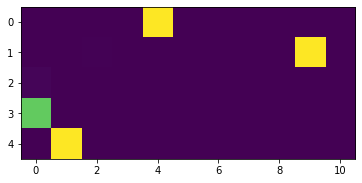

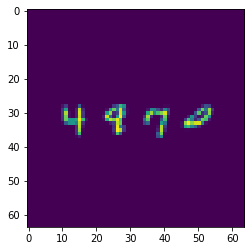

          Label
Id             
12168  65101010


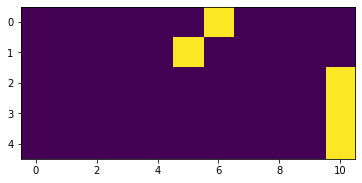

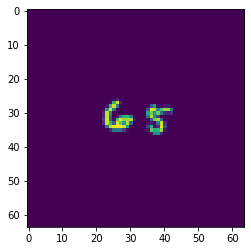

          Label
Id             
12169  28101010


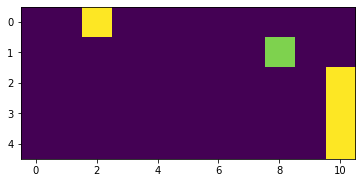

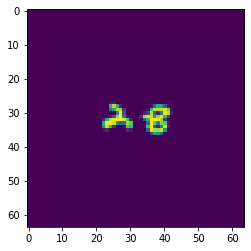

       Label
Id          
12170  73421


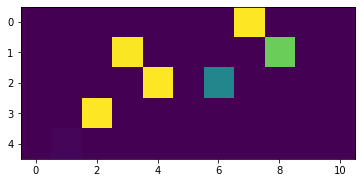

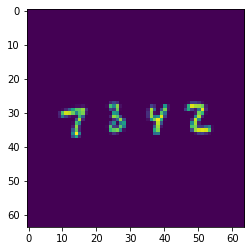

       Label
Id          
12171  17881


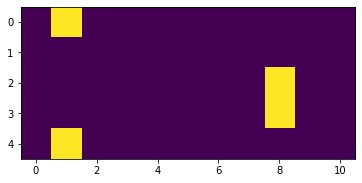

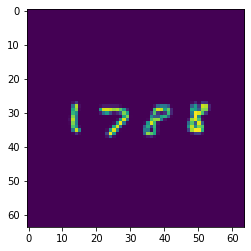

       Label
Id          
12172  57504


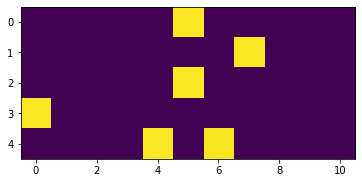

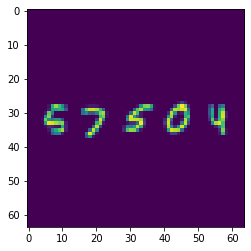

In [14]:
def showWithColour(img):
    img = np.array(img, dtype='float')
    imgShape = (img.shape[0], img.shape[1])
    pixels = img.reshape(imgShape)
    plt.imshow(pixels)
    plt.show()
    
preds = model.predict(validation)
labels,indices = [],[]
for i in range(len(validation)):
    arr = []
    label = ''
    for p in preds[i]:
        arr.append(np.argmax(p))
    for num in arr:
        label += str(num)
    indices.append(i)
    labels.append(label)
d = {'Label': labels}
df = pandas.DataFrame(data=d)
df.index.names = ['Id']
df.to_csv('test_prediction.csv', float_format='{:f}'.format, encoding='utf-8')

start_idx = randint(0,len(validation)-10)
end_idx = start_idx+10
for i in range(start_idx, end_idx):
    print(df.loc[[i]])
    showWithColour(preds[i])
    showWithColour(validation[i])